In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures
from pathlib import Path
from typing import Literal

from datautilities import meshmethods as mm
from datautilities import MeshIO as io

sns.set_theme()

In [2]:
lr_res = "LR8_raw_6cpu"
hr_res = "HR_6cpu"
# train_years = [1959, 1960, 1961, 1962, 1963]
train_years = [1959]
test_years = 1964
nyears = len(train_years)
nregion = 3
region_str = f"region{nregion}"

root_dir = Path(f"../Data/Region{nregion}LR4/")

lr_mesh = io.load_mesh(root_dir / "LR8_mesh.pickle")
mesh = io.load_mesh(root_dir / "HR_mesh.pickle")

In [3]:
class PreProcessing:
    def __init__(self):
        self.mean = None
        self.std = None

        self.pca = None

    @staticmethod
    def delete_nans(X: np.ndarray):
        """X has to be of shape (nsamples, nfeatures)"""
        nan_idx = np.nonzero(np.isnan(X).all(axis=0))[0]
        return np.delete(X, nan_idx, axis=1)

    def znormalize(self, X: np.ndarray):
        if self.mean is None or self.std is None:
            raise ValueError(
                ("Either 'self.mean or self.std is 'None'. Precompute them "
                 "by calling znormalize_fit first.")
            )
        return (X - self.mean) / self.std

    def znormalize_fit(self, X: np.ndarray):
        """Precompute mean and std of data set for later normalization"""
        self.mean = np.nanmean(X, axis=0)
        self.std = np.nanstd(X, axis=0)

    def pca_transform(self, X: np.ndarray):
        """Wrapper around sklearn's 'PCA.transform()' method"""
        if self.pca is None:
            raise ValueError(
                "No PCA instance found. Call pca_fit first to transform data."
            )
        return self.pca.transform(X)

    def pca_fit(self, X: np.ndarray, **kwargs):
        """Fit PCA instance. Kwargs are passed to pca initialization."""
        pca = PCA(**kwargs)
        self.pca = pca.fit(X)

    @staticmethod
    def polynomial_transform(X: np.ndarray, degree: int = 2):
        return PolynomialFeatures(degree=degree).fit_transform(X)

def preprocessing_pipeline(
    pp: PreProcessing,
    X: np.ndarray,
    y: np.ndarray,
    mode: Literal["train", "test"] = "train",
    delete_nans: bool = True,
    polynomials: int = 2,
    znormalize: bool = True,
    pca_transform: bool = True,
    **kwargs
) -> tuple[PreProcessing, np.ndarray, np.ndarray]:
    """Pipeline that processes input and target data. The preprocessing
    class stores the data that is necessary to perform later transforms.

    Parameters
    ----------
    pp : PreProcessing
        PreProcessing instance that is used to store or retrieve parameters
        to correctly preprocess the data
    X : np.ndarray
        Input data to be preprocessed. Assumed shape: (nsamples, nfeatures)
    y : np.ndarray
        Target data to be preprocessed. Assumed shape: (nsamples, nfeatures)
    mode : Literal['train', 'test'], optional
        If data should be fitted or just transformed, by default "train"
    delete_nans : bool
        If delete_nans should be called. Otherwise nan_to_num is used
        to treat nan data. By default True
    polynomials : int
        If 0, no polynomials are added. If > 0 then this is used as the
        degree of the polynomials. By default 0
    znormalize : bool
        If input should be znormalized, by default True
    pca_transform : bool
        If input should be pca-transformed, by default True
    **kwargs :
        Keyword arguments are passed to pca_fit

    Returns
    -------
    tuple[PreProcessing, np.ndarray, np.ndarray]
        Returns 'PreProcessing' instance with the stored parameters and the
        transformed inputs and targets
    """
    if delete_nans:
        X = pp.delete_nans(X)
        y = pp.delete_nans(y)
    else:
        X = np.nan_to_num(X)
        y = np.nan_to_num(y)

    if polynomials:
        X = pp.polynomial_transform(X, degree=polynomials)

    if mode == "train":
        pp.znormalize_fit(X)
        pp.pca_fit(X, **kwargs)

    if znormalize:
        X = pp.znormalize(X)
    if pca_transform:
        X = pp.pca_transform(X)

    return pp, X, y


In [4]:
pp = PreProcessing()

X = mm.load_data(res=lr_res, years=train_years, root_dir=root_dir)

y = mm.load_data(res=hr_res, years=train_years, root_dir=root_dir)

kwargs = dict(
    delete_nans=False,
    polynomials=1,
    pca_transform=False,
    znormalize=False,
    whiten=False,
)

pp, X, y = preprocessing_pipeline(pp, X, y, **kwargs)

reg = LinearRegression(fit_intercept=False)
reg = reg.fit(X, y)

X_test = mm.load_data(res=lr_res, years=test_years, root_dir=root_dir)
y_test = mm.load_data(res=hr_res, years=test_years, root_dir=root_dir)

pp, X_test, y_test = preprocessing_pipeline(
        pp, X_test, y_test, mode="test", **kwargs
    )

pred_lin = reg.predict(X_test)

/home/jannik/Documents/PhD/Super_Resolution_General/SROnUnstructuredGrids/datautilities/datautilities/meshmethods.py:106: RuntimeWarning: invalid value encountered in cast
  data[idx] = np.load(fpath).squeeze()
/home/jannik/Documents/PhD/Super_Resolution_General/SROnUnstructuredGrids/datautilities/datautilities/meshmethods.py:106: RuntimeWarning: invalid value encountered in cast
  data[idx] = np.load(fpath).squeeze()


In [5]:
pp = PreProcessing()

X = mm.load_data(res=lr_res, years=train_years, root_dir=root_dir)

y = mm.load_data(res=hr_res, years=train_years, root_dir=root_dir)

kwargs = dict(
    delete_nans=False,
    polynomials=2,
    pca_transform=False,
    znormalize=False,
    whiten=False,
)

pp, X, y = preprocessing_pipeline(pp, X, y, **kwargs)

reg = Ridge(0.005, fit_intercept=False)
reg = reg.fit(X, y)

X_test = mm.load_data(res=lr_res, years=test_years, root_dir=root_dir)
y_test = mm.load_data(res=hr_res, years=test_years, root_dir=root_dir)

pp, X_test, y_test = preprocessing_pipeline(
        pp, X_test, y_test, mode="test", **kwargs
    )

pred_poly = reg.predict(X_test)

/home/jannik/Documents/PhD/Super_Resolution_General/SROnUnstructuredGrids/datautilities/datautilities/meshmethods.py:106: RuntimeWarning: invalid value encountered in cast
  data[idx] = np.load(fpath).squeeze()
/home/jannik/anaconda3/envs/ugrid/lib/python3.10/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/jannik/Documents/PhD/Super_Resolution_General/SROnUnstructuredGrids/datautilities/datautilities/meshmethods.py:106: RuntimeWarning: invalid value encountered in cast
  data[idx] = np.load(fpath).squeeze()


In [6]:
# Set 0s to nan
y_test[y_test == 0] = np.nan

# Performance data
mae_lin = np.nanmean(np.abs(pred_lin - y_test))
rmse_lin = np.sqrt(np.nanmean(np.abs(pred_lin - y_test)**2))
max_lin = np.nanmax(np.abs(pred_lin - y_test))
r2_lin = np.corrcoef(pred_lin.flatten(), y_test.flatten())[0, 1]**2

mae_poly = np.nanmean(np.abs(pred_poly - y_test))
rmse_poly = np.sqrt(np.nanmean(np.abs(pred_poly - y_test)**2))
max_poly = np.nanmax(np.abs(pred_poly - y_test))
r2_poly = np.corrcoef(pred_poly.flatten(), y_test.flatten())[0, 1]**2

# Save performance data in dataframe
perf_lin = dict(
    mae=mae_lin,
    rmse=rmse_lin,
    max_err=max_lin,
    r2=r2_lin
)

perf_poly = dict(
    mae=mae_poly,
    rmse=rmse_poly,
    max_err=max_poly,
    r2=r2_poly
)

perf_comb = dict()
perf_comb[f"lin_reg{nyears}"] = perf_lin
perf_comb[f"poly_reg{nyears}"] = perf_poly

perf_df = pd.DataFrame(perf_comb).T

out_path = Path("performances") / region_str / f"perfs_{nyears}years.csv"
out_path.parent.mkdir(exist_ok=True, parents=True)
perf_df.to_csv(out_path)

In [7]:
print("Linear regression model")
print("-------------------")
print("MAE:", mae_lin)
print("RMSE:", rmse_lin)
print("Max:", max_lin)
print("R^2:", r2_lin)

print("Polynomial regresssion model")
print("-------------------")
print("MAE:", mae_poly)
print("RMSE:", rmse_poly)
print("Max:", max_poly)
print("R^2:", r2_poly)

Linear regression model
-------------------
MAE: 0.0021895759325082655
RMSE: 0.0038360728979683336
Max: 0.13613915038285151
R^2: 0.9999554116163699
Polynomial regresssion model
-------------------
MAE: 0.0018340942425932416
RMSE: 0.00300221161906036
Max: 0.05719104270577513
R^2: 0.9999727256955447


# Density plot comparison - Linear vs Polynomial Regression

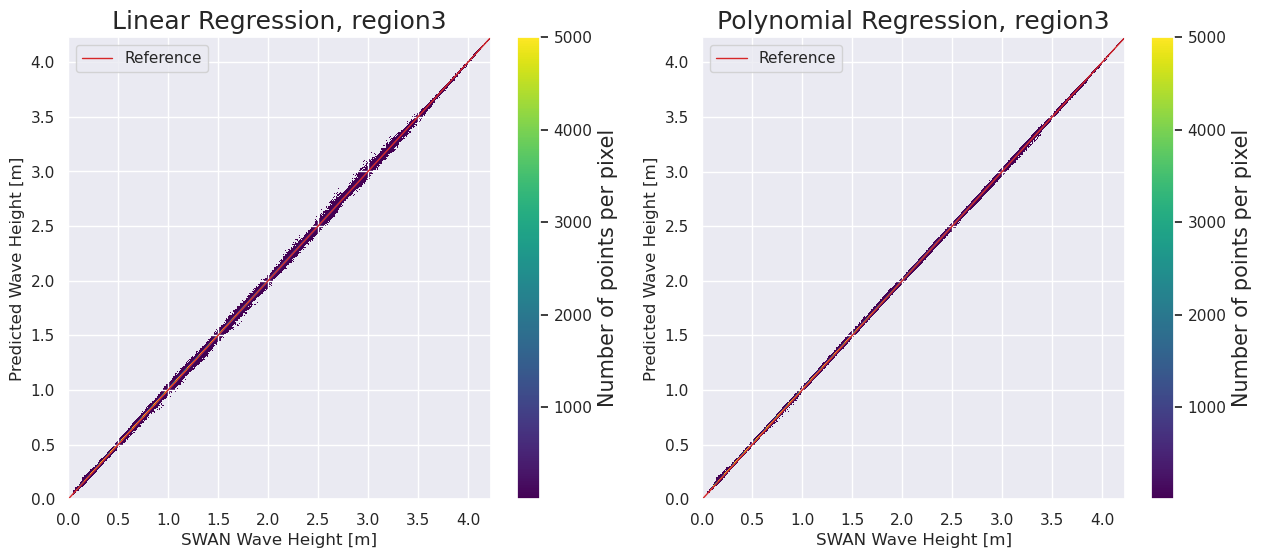

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

plt.rcParams["axes.labelsize"] = 15
plt.rcParams["axes.titlesize"] = 18

vmax = 5000

mm.scatter_density(y_test.flatten(), pred_lin.flatten(), ax=axs[0], vmax=vmax)
mm.scatter_density(y_test.flatten(), pred_poly.flatten(), ax=axs[1], vmax=vmax)

axs[0].axline([0, 0], [1, 1], color="tab:red", lw=1, ls="-", label="Reference")
axs[1].axline([0, 0], [1, 1], color="tab:red", lw=1, ls="-", label="Reference")

axs[0].set_xlabel("SWAN Wave Height [m]")
axs[1].set_xlabel("SWAN Wave Height [m]")

axs[0].set_ylabel("Predicted Wave Height [m]")
axs[1].set_ylabel("Predicted Wave Height [m]")

axs[0].set_title("Linear Regression, " + region_str)
axs[1].set_title("Polynomial Regression, " + region_str)

axs[0].legend()
axs[1].legend()

out_path = Path("plots") / region_str / f"density-plot-{nyears}years"
out_path.parent.mkdir(exist_ok=True, parents=True)
plt.savefig(out_path, bbox_inches="tight")
plt.show()

# Error map plots

/tmp/ipykernel_41739/1780139928.py:4: RuntimeWarning: Mean of empty slice
  diff_lin = np.nanmean(np.abs(pred_lin - y_test), axis=0)*100
/tmp/ipykernel_41739/1780139928.py:5: RuntimeWarning: Mean of empty slice
  diff_poly = np.nanmean(np.abs(pred_poly - y_test), axis=0)*100


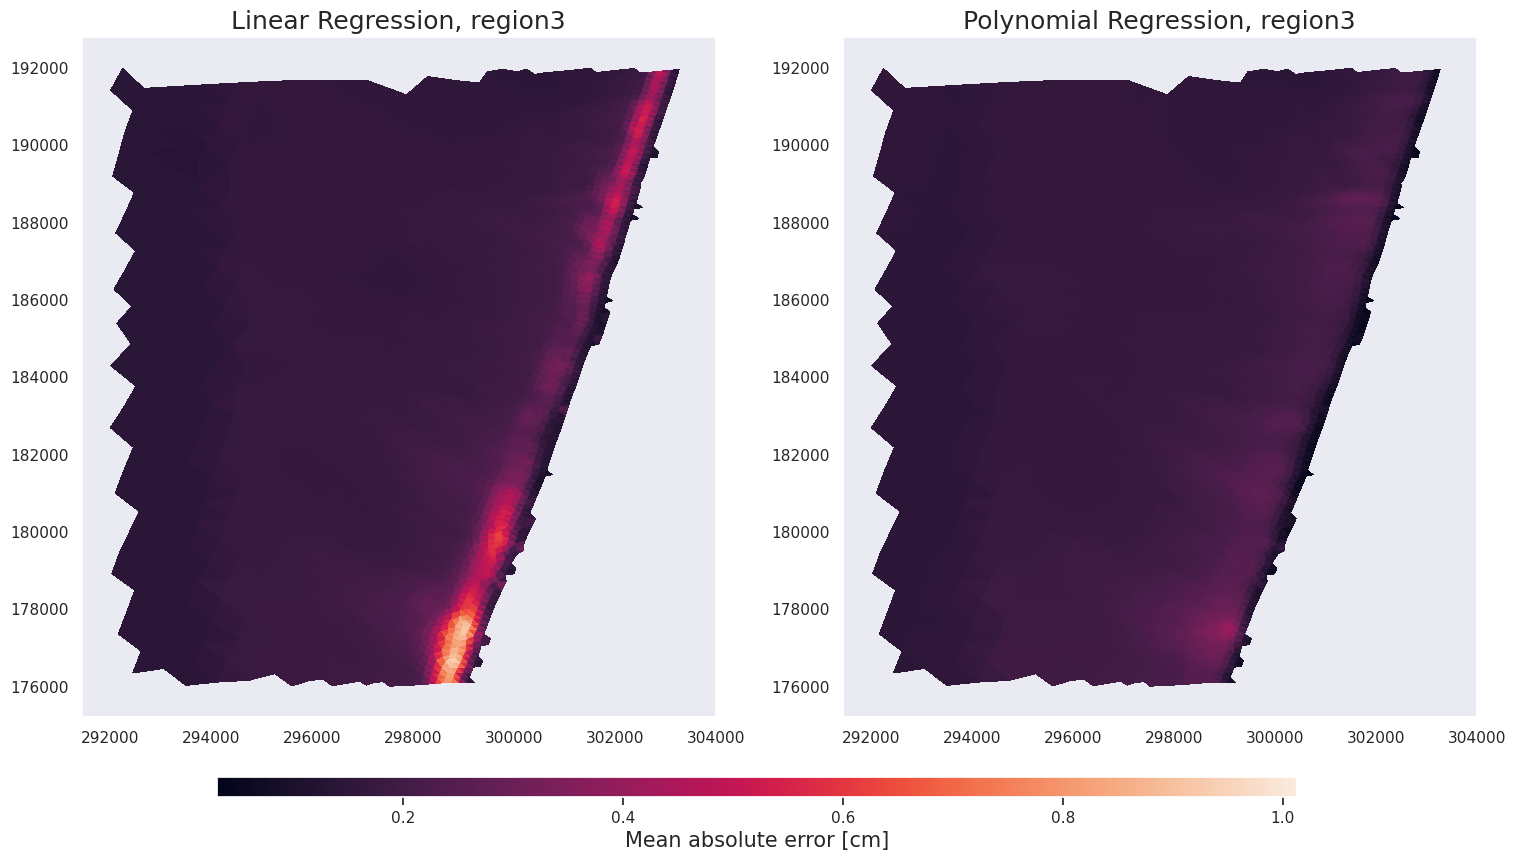

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(18, 10))

y_test[y_test == 0] = np.nan
diff_lin = np.nanmean(np.abs(pred_lin - y_test), axis=0)*100
diff_poly = np.nanmean(np.abs(pred_poly - y_test), axis=0)*100

vmin = np.nanmin(np.r_[diff_lin, diff_poly])
vmax = np.nanmax(np.r_[diff_lin, diff_poly])

mm.plot_meshed_data(diff_lin, mesh, ax=axs[0], vmin=vmin, vmax=vmax)
im = mm.plot_meshed_data(diff_poly, mesh, ax=axs[1], vmin=vmin, vmax=vmax)

axs[0].set_title("Linear Regression, " + region_str)
axs[1].set_title("Polynomial Regression, " + region_str)

# Colorbar [left, bottom, width, height
fig.subplots_adjust(bottom=0.2)
cax = fig.add_axes([0.2, 0.12, 0.6, 0.02])
cbar = fig.colorbar(im, cax, orientation='horizontal')
cbar.set_label("Mean absolute error [cm]")


out_path = Path("plots") / region_str / f"errormap-{nyears}years"
out_path.parent.mkdir(exist_ok=True, parents=True)
plt.savefig(out_path, dpi=450, bbox_inches="tight")
plt.show()